In [25]:
import pandas as pd
import numpy as np
import re
import os
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
os.makedirs("../models", exist_ok=True)

df = pd.read_csv("../data/dataset.csv")
df.columns = df.columns.str.lower()

print("shape dataset:", df.shape)
df.head()

shape dataset: (20000, 14)


,english,japanese,type,episodes,status,premiered,licensors,studios,source,genres,demographic,rating,score,anime show link
0,Frieren: Beyond Journey's End,葬送のフリーレン,TV,28,Finished Airing,Fall 2023,Crunchyroll,Madhouse,Manga,"AdventureAdventure,DramaDrama,FantasyFantasy",Shounen,PG-13,9.301,https://myanimelist.net/anime/52991/Sousou_no_...
1,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,Finished Airing,Spring 2009,"Funimation,Aniplex of America",Bones,Manga,"ActionAction,AdventureAdventure,DramaDrama,Fan...",Shounen,R - 17,9.101,https://myanimelist.net/anime/5114/Fullmetal_A...
2,Steins;Gate,STEINS;GATE,TV,24,Finished Airing,Spring 2011,Funimation,White Fox,Visual novel,"DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",NaN,PG-13,9.071,https://myanimelist.net/anime/9253/Steins_Gate
3,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,Finished Airing,Spring 2019,Funimation,Wit Studio,Manga,"ActionAction,DramaDrama,SuspenseSuspense",Shounen,R - 17,9.051,https://myanimelist.net/anime/38524/Shingeki_n...
4,Gintama Season 4,銀魂°,TV,51,Finished Airing,Spring 2015,"Funimation,Crunchyroll",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",Shounen,PG-13,9.051,https://myanimelist.net/anime/28977/Gintama°


In [27]:
cat_cols = [
  "type", "status", "premiered", "licensors", "studios", "source", "genres"
]

for col in cat_cols:
  df[col] = df[col].fillna("Unknown")

In [28]:
def clean_episode(x):
  if pd.isna(x):
    return np.nan
  m = re.search(r"\d+", str(x))
  return int(m.group()) if m else np.nan

df["episodes"] = df["episodes"].apply(clean_episode)
df["episodes"] = df["episodes"].fillna(df["episodes"].median())

In [29]:
def clean_genres(genres):
    if pd.isna(genres):
        return "UnknownGenre"

    genres = str(genres).strip()

    if genres.lower() == "unknown" or genres == "":
        return "UnknownGenre"

    cleaned = []
    for g in genres.split(","):
        g = g.strip()

        if len(g) % 2 == 0 and g[:len(g)//2] == g[len(g)//2:]:
            g = g[:len(g)//2]

        cleaned.append(g)

    return ", ".join(cleaned)

df["genres"] = df["genres"].apply(clean_genres)

In [30]:
df["genre_list"] = df["genres"].apply(
    lambda x: x.split(", ")
)

In [31]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df["genre_list"])

genre_df = pd.DataFrame(
  genre_matrix,
  columns=[f"genre_{g}" for g in mlb.classes_]
)

print("Jumlah genre unik:", genre_df.shape[1])

Jumlah genre unik: 20


In [32]:
type_df = pd.get_dummies(df["type"], prefix="type")

In [33]:
X = pd.concat(
    [
        genre_df,
        type_df,
        df[["episodes"]]
    ],
    axis=1
)

print("Shape X:", X.shape)

Shape X: (20000, 28)


In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

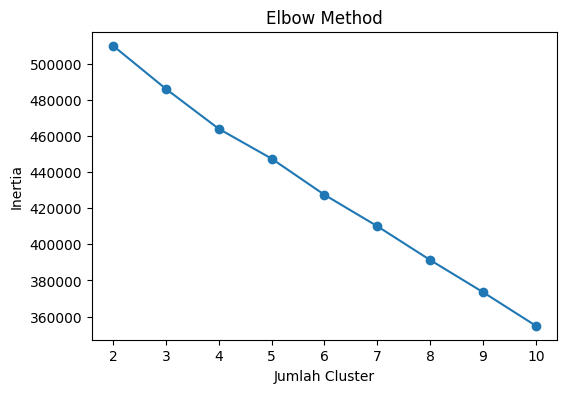

In [35]:
inertia = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.title("Elbow Method")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.show()

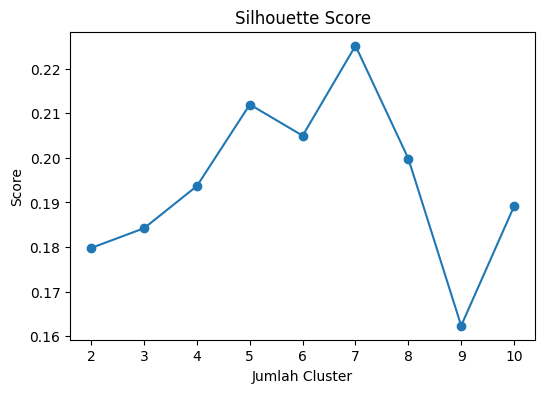

In [36]:
sil_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,4))
plt.plot(K, sil_scores, marker="o")
plt.title("Silhouette Score")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Score")
plt.show()

In [41]:
k_final = 7

kmeans = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=20
)

df["cluster"] = kmeans.fit_predict(X_scaled)

print("Training selesai, jumlah cluster:", k_final)

Training selesai, jumlah cluster: 7


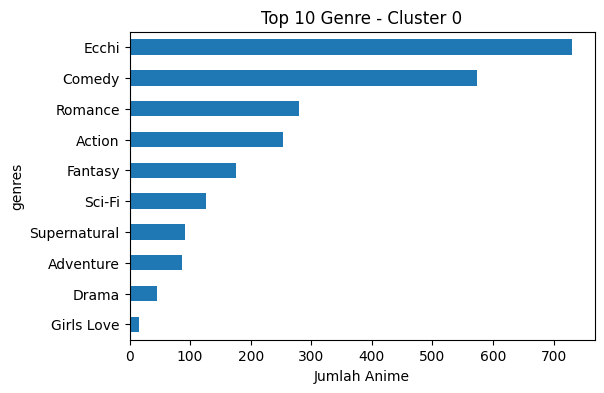

Saved: outputs/cluster_0_top_genres.png


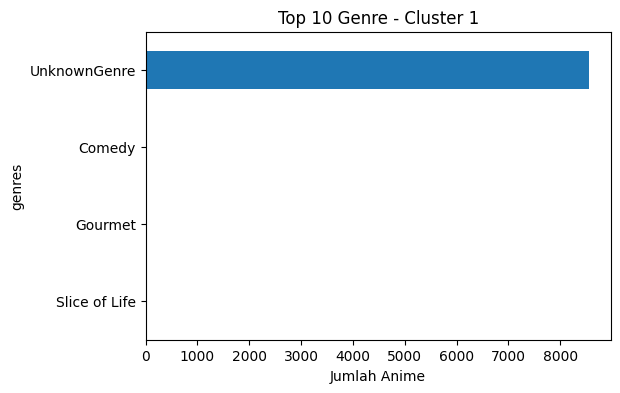

Saved: outputs/cluster_1_top_genres.png


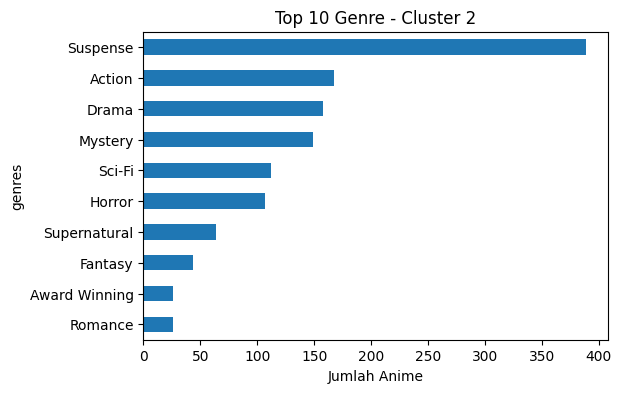

Saved: outputs/cluster_2_top_genres.png


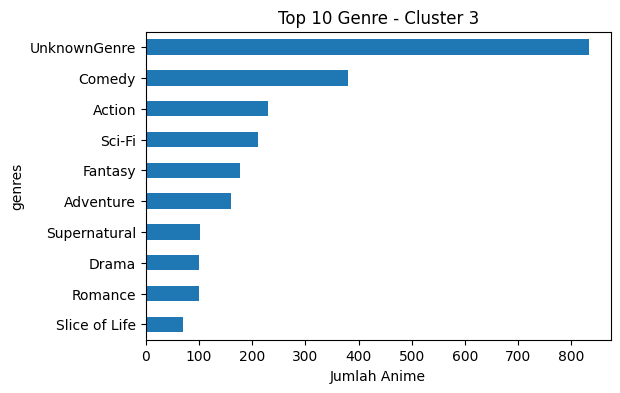

Saved: outputs/cluster_3_top_genres.png


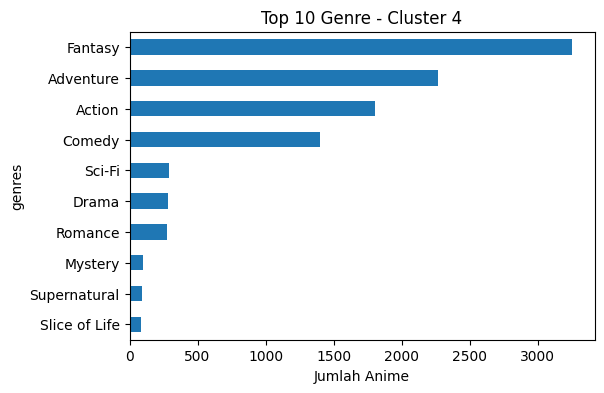

Saved: outputs/cluster_4_top_genres.png


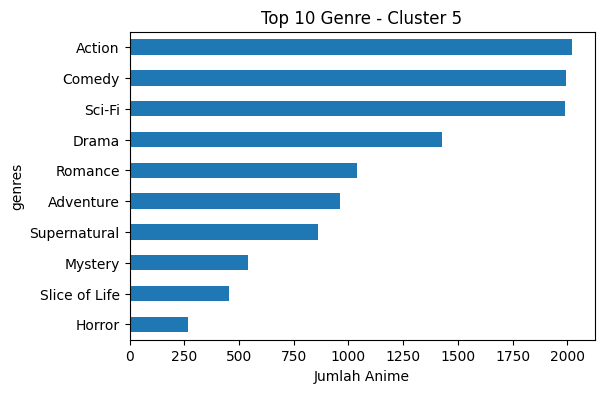

Saved: outputs/cluster_5_top_genres.png


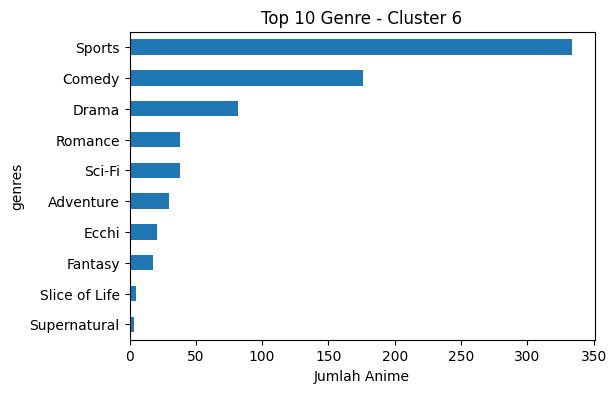

Saved: outputs/cluster_6_top_genres.png


In [42]:
import collections
import matplotlib.pyplot as plt

df["genres"] = df["genres"].fillna("").astype(str)

for c in sorted(df["cluster"].unique()):
    cluster_df = df[df["cluster"] == c]

    all_genres = (
        cluster_df["genres"]
        .str.split(",")
        .explode()
        .str.strip()
    )

    all_genres = all_genres[all_genres != ""]

    genre_counts = all_genres.value_counts().head(10)

    if genre_counts.empty:
        print(f"Skipping cluster {c}: No genres found.")
        continue
    plt.figure(figsize=(6, 4))
    genre_counts.plot(kind="barh")
    
    plt.title(f"Top 10 Genre - Cluster {c}")
    plt.xlabel("Jumlah Anime")
    plt.gca().invert_yaxis()

    plt.savefig(
        f"../outputs/cluster_{c}_top_genres.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()

    print(f"Saved: outputs/cluster_{c}_top_genres.png")

In [43]:
joblib.dump(kmeans, "../models/kmeans.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
joblib.dump(mlb, "../models/mlb.pkl")
joblib.dump(X_scaled, "../models/X_scaled.pkl")

df.to_csv("../models/anime_with_clusters.csv", index=False)

print("Model & data berhasil disimpan ke folder models/")

Model & data berhasil disimpan ke folder models/


In [44]:
print(df[["english", "genres", "cluster"]].head(10))

                            english                             genres  \
0     Frieren: Beyond Journey's End          Adventure, Drama, Fantasy   
1  Fullmetal Alchemist: Brotherhood  Action, Adventure, Drama, Fantasy   
2                       Steins;Gate            Drama, Sci-Fi, Suspense   
3   Attack on Titan Season 3 Part 2            Action, Drama, Suspense   
4                  Gintama Season 4             Action, Comedy, Sci-Fi   
5           Gintama: The Very Final      Action, Comedy, Drama, Sci-Fi   
6                               NaN         Action, Adventure, Fantasy   
7                   Hunter x Hunter         Action, Adventure, Fantasy   
8                  Gintama Season 2             Action, Comedy, Sci-Fi   
9                Gintama: Enchousen             Action, Comedy, Sci-Fi   

   cluster  
0        4  
1        4  
2        2  
3        2  
4        5  
5        5  
6        4  
7        4  
8        5  
9        5  
